In [2]:
import os
import sys

import zipfile
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from torchvision import datasets,transforms
from torchvision.utils import make_grid

import warnings 
warnings.filterwarnings("ignore")

from IPython.display import display

from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/CATS_DOGS.zip"
zip_files = zipfile.ZipFile(file = path , mode = "r")
zip_files.extractall()
zip_files.close()

In [4]:
path = "/content/CATS_DOGS"

for folder, subfolders , filenames in os.walk(path):
    print(folder, "******", subfolders, "******", filenames)

/content/CATS_DOGS ****** ['train', 'test'] ****** []
/content/CATS_DOGS/train ****** ['CAT', 'DOG'] ****** []
/content/CATS_DOGS/train/CAT ****** [] ****** ['3316.jpg', '12.jpg', '735.jpg', '8773.jpg', '1362.jpg', '8601.jpg', '5382.jpg', '3709.jpg', '3970.jpg', '3026.jpg', '6291.jpg', '4384.jpg', '1118.jpg', '2353.jpg', '8061.jpg', '9317.jpg', '4533.jpg', '6647.jpg', '7193.jpg', '9161.jpg', '96.jpg', '5708.jpg', '2995.jpg', '6761.jpg', '4753.jpg', '1313.jpg', '5309.jpg', '6994.jpg', '7117.jpg', '6219.jpg', '1773.jpg', '5413.jpg', '3650.jpg', '7867.jpg', '5271.jpg', '8438.jpg', '5931.jpg', '5692.jpg', '637.jpg', '5225.jpg', '4919.jpg', '6788.jpg', '662.jpg', '2339.jpg', '4397.jpg', '6110.jpg', '7949.jpg', '1486.jpg', '1166.jpg', '2848.jpg', '4227.jpg', '4549.jpg', '3520.jpg', '4655.jpg', '8286.jpg', '89.jpg', '3486.jpg', '814.jpg', '5171.jpg', '5591.jpg', '1691.jpg', '5438.jpg', '1953.jpg', '4026.jpg', '8081.jpg', '4586.jpg', '8939.jpg', '2328.jpg', '3530.jpg', '8002.jpg', '9307.jpg', 

In [5]:
img_names = []
for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder + "/" + img)

In [6]:
len(img_names)

24994

In [7]:
img_names[:2]

['/content/CATS_DOGS/train/CAT/3316.jpg',
 '/content/CATS_DOGS/train/CAT/12.jpg']

In [12]:
img_sizes = []
rejected = []

for item in img_names:

    try :

        with Image.open(item) as img:
            img_sizes.append(img.size)

    except :

        rejected.append(item)

In [17]:
print("Images : ", len(img_sizes))
print("Rejects : ",len(rejected))

Images :  24994
Rejects :  0


In [14]:
img_sizes[:2]

[(500, 375), (300, 225)]

In [15]:
df = pd.DataFrame(img_sizes)
df.columns = ["Width", "Height"]
df.head()

,Width,Height
0,500,375
1,300,225
2,220,189
3,500,369
4,496,500


In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Width,24994.0,404.493518,108.941802,42.0,323.0,448.0,500.0,500.0
Height,24994.0,361.037129,96.936811,33.0,302.0,375.0,421.0,500.0


Size :  (500, 387)



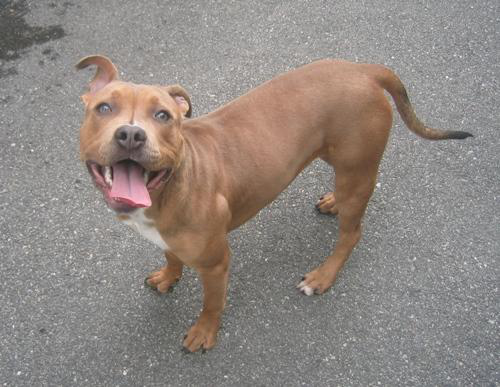

In [25]:
dog = Image.open("/content/CATS_DOGS/train/DOG/14.jpg")
print("Size : ", dog.size)
print()
display(dog)

In [26]:
np.array(dog).max(),np.array(dog).min()

(255, 21)

In [27]:
r, g, b = dog.getpixel((0,0))
print(r,g,b)

90 95 98


In [28]:
transform = transforms.Compose([
                                transforms.ToTensor()
])

im = transform(dog)
print(type(im))
print(im.shape)
print(im.max(), im.min())

<class 'torch.Tensor'>
torch.Size([3, 387, 500])
tensor(1.) tensor(0.0824)


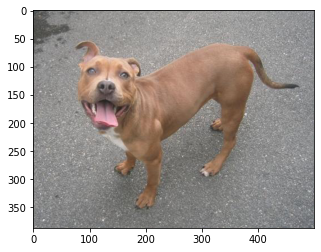

In [29]:
# (Height, Width, Channel) # np.transpose(im,(1,2,0))

show = np.transpose(im.numpy(), (1,2,0))
plt.imshow(show)
plt.show()

In [30]:
im[:,0,0]

tensor([0.3529, 0.3725, 0.3843])

In [31]:
# Normalize İşlemi !!!

np.array(dog.getpixel((0,0)) ) / 255

array([0.35294118, 0.37254902, 0.38431373])

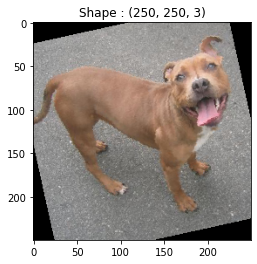

In [73]:
dog = Image.open("/content/CATS_DOGS/train/DOG/14.jpg")

transform = transforms.Compose([
                                transforms.ToTensor(), # [0,1] arasına dönüştürüyor
                                transforms.Resize(250), # if height > width --> (size*height / width, size). (250,250) olabilir
                                transforms.CenterCrop(250), # (250,250) olarak center noktasından kesiyor
                                transforms.RandomHorizontalFlip(p = 1),
                                transforms.RandomRotation(degrees=30) # -30 yada +30 !!!
])          


im = transform(dog)
show = np.transpose( im.numpy() , (1,2,0) )
plt.imshow(show)
plt.title(f"Shape : {show.shape}")
plt.show()

In [50]:
im[0].mean(),im[1].mean(),im[2].mean(),"---",im[0].std(),im[1].std(),im[2].std()

(tensor(0.4895),
 tensor(0.4451),
 tensor(0.4162),
 '---',
 tensor(0.2242),
 tensor(0.2053),
 tensor(0.2033))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


----------------------------------------------------------------------------------------------------
Max :  tensor(2.5529) Min :  tensor(-1.5980)
----------------------------------------------------------------------------------------------------


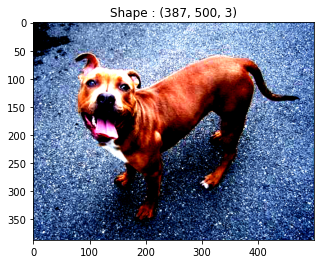

In [63]:
#output[channel] = (input[channel] - mean[channel]) / std[channel]

#Args:
#    mean (sequence): Sequence of means for each channel.
#    std (sequence): Sequence of standard deviations for each channel.
#    inplace(bool,optional): Bool to make this operation in-place.

dog = Image.open("/content/CATS_DOGS/train/DOG/14.jpg")

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                                     std = [0.229,0.224,0.225])
])

im = transform(dog)
print("".center(100,"-"))
print("Max : ", im.max(), "Min : ",im.min())
print("".center(100,"-"))
show = np.transpose( im.numpy(), (1,2,0))
plt.imshow(show)
plt.title(f"Shape : {show.shape}")
plt.show()

In [64]:
#Before Normalization 
# tensor([0.3529, 0.3725, 0.3843])

# After Normalization 
im[:,0,0]

tensor([-0.5767, -0.3725, -0.0964])

----------------------------------------------------------------------------------------------------
Max :  tensor(1.) Min :  tensor(0.0824)
----------------------------------------------------------------------------------------------------


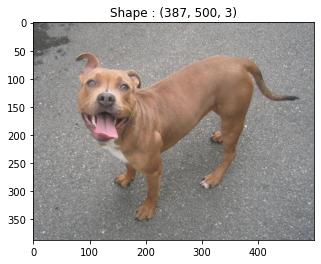

In [67]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

im_inv = inv_normalize(im)
print("".center(100,"-"))
print("Max : ", im_inv.max(), "Min : ",im_inv.min())
print("".center(100,"-"))

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1,2,0)))
plt.title(f"Shape : {show.shape}")
plt.show()

---

In [69]:
train_transform = transforms.Compose([
                                      transforms.RandomRotation(degrees = 10), # Saat Yönünde
                                      transforms.RandomHorizontalFlip(p = 0.5),
                                      transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                                           std = [0.229,0.224,0.225]) # output = (value - mean) / std
])

In [70]:
test_transform = transforms.Compose([
                                      transforms.RandomRotation(degrees = 10), # Saat Yönünde
                                      transforms.RandomHorizontalFlip(p = 0.5),
                                      transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                                           std = [0.229,0.224,0.225]) # output = (value - mean) / std
])

In [75]:
root = "/content/CATS_DOGS"

train_data = datasets.ImageFolder(os.path.join(root, "train"), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, "test"), transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size = 10, shuffle =True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)

class_names = train_data.classes

print()
print(class_names)
print(f"Training Images Available : {len(train_data)}")
print(f"Testing Images Available : {len(test_data)}")


['CAT', 'DOG']
Training Images Available : 18743
Testing Images Available : 6251


Label :  [1 1 0 0 1 1 0 1 0 0]
Class :  DOG DOG CAT CAT DOG DOG CAT DOG CAT CAT


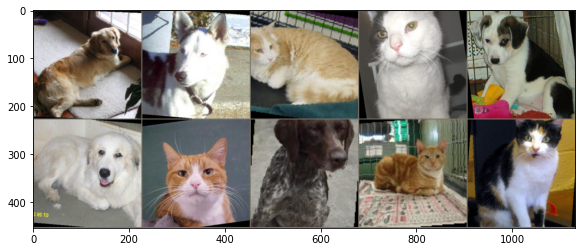

In [76]:
for images, labels in train_loader:
    break

print("Label : ", labels.numpy())
print("Class : ", *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow = 5)

inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                     std=[1/0.229, 1/0.224, 1/0.225]
                                    )

im_inv = inv_normalize(im)

plt.figure(figsize = (12,4))
plt.imshow(np.transpose( im_inv.numpy(), (1,2,0)))
plt.show()

In [78]:
images.shape,labels.shape

(torch.Size([10, 3, 224, 224]), torch.Size([10]))

In [79]:
(((224 - 2) / 2) -2) /2

54.5

In [80]:
class CNN(nn.Module):

    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):

        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X , 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim = 1)

In [90]:
torch.manual_seed(101)

CNNmodel = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr = 0.001)

In [91]:
CNNmodel

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [92]:
#for name, param in CNNmodel.named_parameters():
#    print(name, "\t" , param)
#    print("".center(200,"-"))

In [93]:
total = []
for p in CNNmodel.parameters():
    print(p.numel())
    total.append(p.numel())

print("".center(10,"_"))
print(np.sum(total))

162
6
864
16
5598720
120
10080
84
840
10
__________
5610902


In [94]:
len(train_data),len(test_data)

(18743, 6251)

In [95]:
import time

start_time = time.time()
epochs = 3

max_trn_batch = 800 
max_tst_batch = 300 

train_losses = []
test_losses = []
train_correct = []
test_correct = []


for i in range(epochs):

    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):

        if b == max_trn_batch:
            break

        b +=1

        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)


        predicted = torch.max(y_pred, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr +=batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 200 == 0:
                print(f'Epoch: {i:2} , Batch: {b:4} [{10*b:6}/8000] , Loss: {loss.item():10.8f} , Accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)


    with torch.no_grad():

        for b,(X_test, y_test) in enumerate(test_loader):

            if b == max_tst_batch:
                break

            y_val = CNNmodel(X_test)

            predicted = torch.max(y_val.data, 1)[1]
            tst_corr +=(predicted == y_test).sum()


    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

total_time = time.time() - start_time
print()
print(f"Total Time : {total_time / 60} Minutes...")

Epoch:  0 , Batch:  200 [  2000/8000] , Loss: 0.73208463 , Accuracy:  55.450%
Epoch:  0 , Batch:  400 [  4000/8000] , Loss: 0.59770513 , Accuracy:  57.500%
Epoch:  0 , Batch:  600 [  6000/8000] , Loss: 0.62140691 , Accuracy:  59.133%
Epoch:  0 , Batch:  800 [  8000/8000] , Loss: 0.59680569 , Accuracy:  60.888%
Epoch:  1 , Batch:  200 [  2000/8000] , Loss: 0.56102967 , Accuracy:  65.450%
Epoch:  1 , Batch:  400 [  4000/8000] , Loss: 1.02416110 , Accuracy:  68.100%
Epoch:  1 , Batch:  600 [  6000/8000] , Loss: 0.37912360 , Accuracy:  69.600%
Epoch:  1 , Batch:  800 [  8000/8000] , Loss: 0.46184593 , Accuracy:  70.438%
Epoch:  2 , Batch:  200 [  2000/8000] , Loss: 0.46662220 , Accuracy:  73.650%
Epoch:  2 , Batch:  400 [  4000/8000] , Loss: 0.63163245 , Accuracy:  73.675%
Epoch:  2 , Batch:  600 [  6000/8000] , Loss: 0.37476403 , Accuracy:  74.517%
Epoch:  2 , Batch:  800 [  8000/8000] , Loss: 0.45021081 , Accuracy:  74.987%

Total Time : 12.739056479930877 Minutes...


In [95]:
torch.save(CNNmodel.state_dict(), "CustomImageCNNModel.pt")

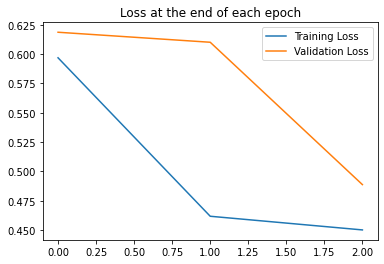

In [97]:
plt.plot(train_losses, label = "Training Loss")
plt.plot(test_losses , label = "Validation Loss")
plt.title("Loss at the end of each epoch")
plt.legend(loc = "best")
plt.show()

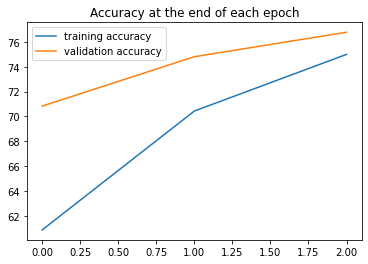

In [98]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend(loc = "best")
plt.show()

In [100]:
print(test_correct)
print(f"Test Accuracy : {test_correct[-1].item()*100 / 3000:.3f}%")

[tensor(2125), tensor(2244), tensor(2303)]
Test Accuracy : 76.767%


---

In [104]:
from torchvision import models,datasets,transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader,TensorDataset

In [105]:
AlexNetModel = models.alexnet(pretrained = True)
AlexNetModel

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [106]:
for param in AlexNetModel.parameters():
    param.requires_grad = False

In [107]:
torch.manual_seed(42)

AlexNetModel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                        nn.ReLU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(1024,2),
                                        nn.LogSoftmax(dim = 1))

AlexNetModel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [109]:
total = []
for param in AlexNetModel.parameters():
    print(param.numel())
    total.append(param.numel())

print("".center(10,"_"))
print(np.sum(total))

23232
64
307200
192
663552
384
884736
256
589824
256
9437184
1024
2048
2
__________
11909954


In [110]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetModel.parameters(), lr = 0.001)

In [112]:
import time

start_time = time.time()

epochs = 1

# Limits on num of batches

max_trn_batch = 800 # batch 100 images --- > 8000 images
max_tst_batch = 300 # 3000 max images

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):

    trn_corr = 0
    tst_corr = 0

    for b, (X_train,y_train) in enumerate(train_loader):

        if b == max_trn_batch:
            break

        b+=1

        y_pred = AlexNetModel(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr +=batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 200 == 0:
            print(f"Epoch : {i:3}, Batch : {b:4} [{10*b:6} / 8000], Loss : {loss.item():.4f}, Accuracy : {trn_corr.item()*100 / (10*b):7.3f}%")

    train_losses.append(loss)
    train_correct.append(trn_corr)


    with torch.no_grad():
        for b,(X_test, y_test) in enumerate(test_loader):

            if b == max_tst_batch:
                break

            y_val = AlexNetModel(X_test)

            predicted = torch.max(y_val, 1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr = tst_corr + batch_corr

    loss = criterion(y_val,y_test)

    test_losses.append(loss)
    test_correct.append(tst_corr)


total_time = time.time() - start_time
print()
print(f"Total Time : {total_time / 60} Minutes")

Epoch :   0, Batch :  200 [  2000 / 8000], Loss : 0.4048, Accuracy :  88.200%
Epoch :   0, Batch :  400 [  4000 / 8000], Loss : 0.0656, Accuracy :  90.025%
Epoch :   0, Batch :  600 [  6000 / 8000], Loss : 0.6102, Accuracy :  91.017%
Epoch :   0, Batch :  800 [  8000 / 8000], Loss : 0.0230, Accuracy :  91.600%

Total Time : 7.5741195996602375 Minutes


In [113]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(2887)]
Test accuracy: 96.233%


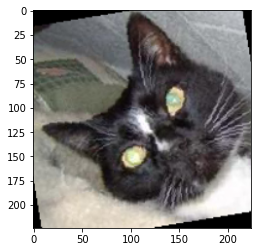

In [114]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

x = 2022

im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose( im.numpy(), (1,2,0)))
plt.show()

In [116]:
CNNmodel.eval()
with torch.no_grad():
    new_pred = CNNmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f"Predicted Value : {new_pred.item()}  {class_names[new_pred.item()]}")

Predicted Value : 0  CAT


In [117]:
AlexNetModel.eval()
with torch.no_grad():
    new_pred = AlexNetModel(test_data[x][0].view(1,3,224,224)).argmax()
print(f"Predicted Value : {new_pred.item()}  {class_names[new_pred.item()]}")

Predicted Value : 0  CAT


In [118]:
# torch max will return both, the 2nd value being the argmax. That is why we used [1]
# Refer to the 2nd part of the document here (torch.max with the dim input):